# Глубокое обучение в науках о данных

# ДЗ 1 Гладышев ВВ

In [18]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D, Input, Dropout, Flatten, Dense, BatchNormalization, MaxPool2D, Activation, MaxPooling2D
from tensorflow.keras.models import Sequential, Model

## Загрузка и подготовка данных

In [4]:
fmnist_test = pd.read_csv("/content/fmnist_test.csv")
fmnist_train = pd.read_csv("/content/fmnist_train.csv")
sample_submission = pd.read_csv("/content/sample_submission.csv")

In [5]:
fmnist_train.isna().sum().sort_values(ascending=False)

,0
pixel784,1
pixel783,1
pixel782,1
pixel781,1
pixel780,1
...,...
pixel22,0
pixel23,0
pixel24,0
pixel25,0


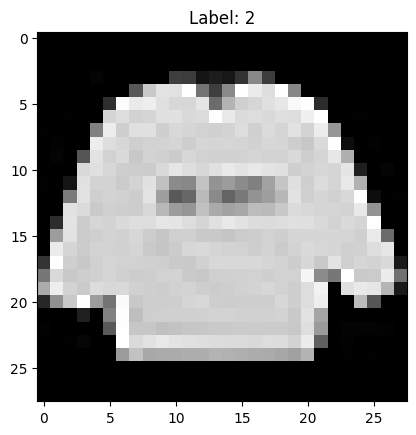

In [6]:
fmnist_train.fillna(0, inplace=True)
X = fmnist_train.drop(columns=["label", "Id"])
y = fmnist_train["label"]
X = X / 255.0

plt.imshow(X.iloc[0].values.reshape(28, 28), cmap='gray')
plt.title(f"Label: {y.iloc[0]}")
plt.show()

In [7]:
X = fmnist_train.drop(columns=["label", "Id"]).values
y = fmnist_train["label"].values
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

y_train_cat = to_categorical(y_train)
y_val_cat = to_categorical(y_val)

In [9]:
X_train.shape[1:]

(784,)

In [10]:
y_train[:10]

array([7, 3, 2, 7, 4, 4, 5, 9, 2, 1])

In [22]:
# изменение размерности массива в 4D массив
X_train_scaled = X_train_scaled.reshape(X_train_scaled.shape[0], 28,28,1)
X_val_scaled = X_val_scaled.reshape(X_val_scaled.shape[0], 28,28,1)

In [23]:
X_train_scaled.shape

(13632, 28, 28, 1)

### Структура модели

In [24]:
filters = 32
lay_cnt = 2

model = Sequential()

# слои нейросети отвественные за свертку и max-pooling
model.add(Conv2D(filters, (3, 3), padding='same',
                input_shape=X_train_scaled.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(filters, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

if not lay_cnt==1:
    model.add(Conv2D(filters*2, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(filters*2, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

# полносвязные слои нейронной сети
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(10))
model.add(Activation('softmax'))

In [31]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 26, 26, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_11 (Activation)      │ (None, 26, 26, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_12 (Activation)      │ (None, 13, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 11, 11, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_13 (Activation)      │ (None, 11, 11, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       819,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_14 (Activation)      │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         5,130 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_15 (Activation)      │ (None, 10)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,669,504 (10.18 MB)

 Trainable params: 889,834 (3.39 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,779,670 (6.79 MB)

### Цикл обучения

In [25]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train_scaled, y_train_cat, epochs=50, batch_size=128, verbose=1, validation_data=(X_val_scaled, y_val_cat))

nn_val_proba = model.predict(X_val_scaled)

Epoch 1/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 11s 61ms/step - accuracy: 0.5803 - loss: 1.1768 - val_accuracy: 0.8060 - val_loss: 0.5180
Epoch 2/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8070 - loss: 0.5213 - val_accuracy: 0.8550 - val_loss: 0.4017
Epoch 3/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8398 - loss: 0.4362 - val_accuracy: 0.8671 - val_loss: 0.3568
Epoch 4/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8585 - loss: 0.3771 - val_accuracy: 0.8762 - val_loss: 0.3450
Epoch 5/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8731 - loss: 0.3334 - val_accuracy: 0.8794 - val_loss: 0.3330
Epoch 6/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8835 - loss: 0.3091 - val_accuracy: 0.8926 - val_loss: 0.2995
Epoch 7/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8970 - loss: 0.2848 - val_accuracy: 0.8897 - val_loss: 0.3010
Epoch 8/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9008 - loss: 0.2610 - val_accuracy: 

## Подготовим тестовые данные и выполним submission

In [28]:
fmnist_test.fillna(0, inplace=True)
X_test = fmnist_test.drop(columns=["Id"])
X_test_scaled = scaler.transform(X_test)
X_test_scaled = X_test_scaled.reshape(X_test_scaled.shape[0], 28,28,1)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


In [30]:
nn_test_proba = model.predict(X_test_scaled)
test_pred_labels = np.argmax(nn_test_proba, axis=1)
sample_submission["label"] = test_pred_labels
sample_submission.to_csv("submission.csv", index=False)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


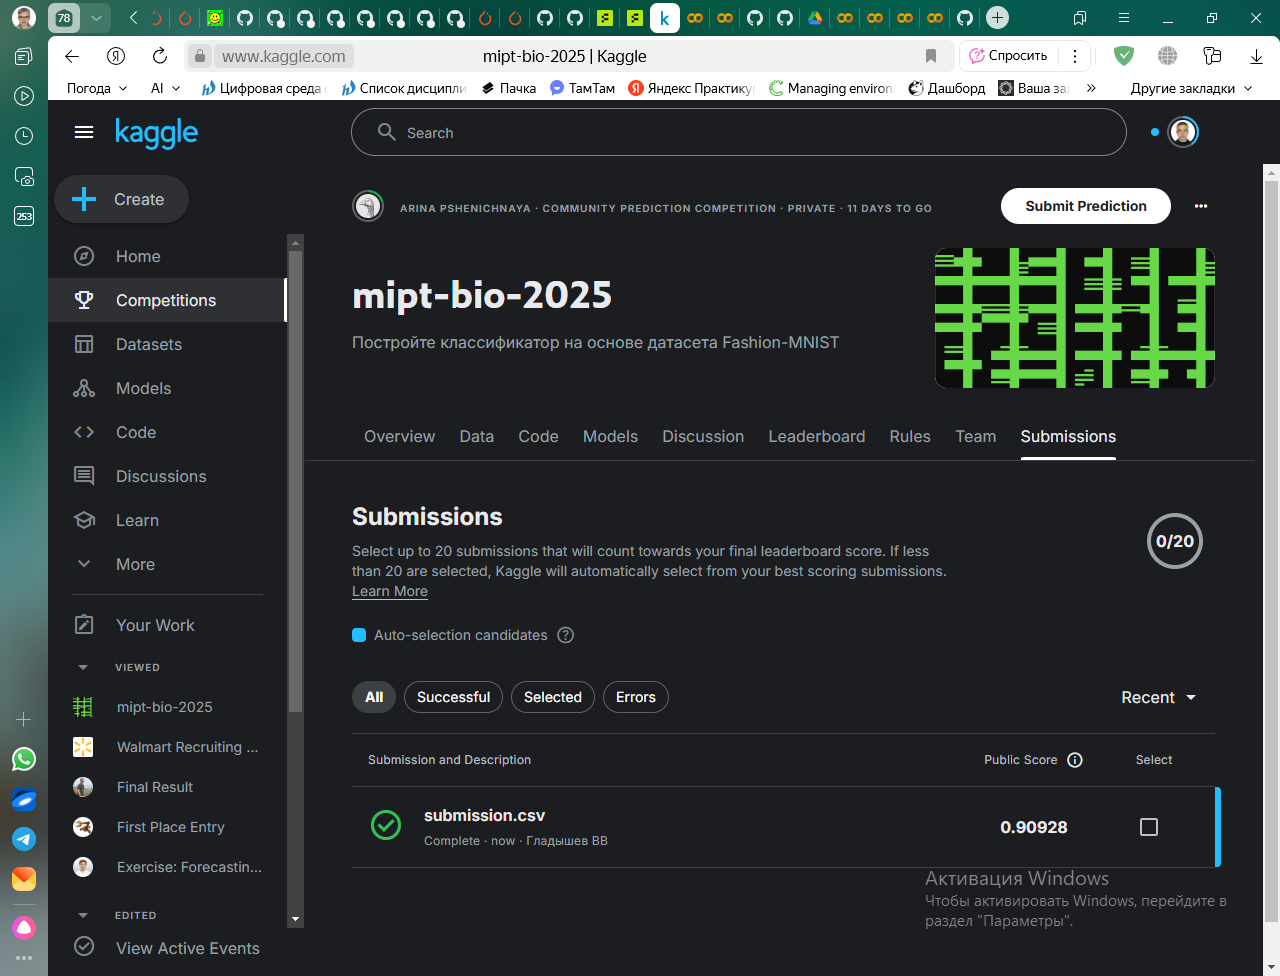

## Выводы

Прменена модель на базе свёрточной архитектуры. Достигнуто значение: 0,90928 accuracy <br>
Параметры модели:
- Total params: 2,669,504 (10.18 MB)
- Trainable params: 889,834 (3.39 MB)
- Optimizer params: 1,779,670 (6.79 MB)